In [ ]:
!git clone https://github.com/ayamohamdd/IP-25.git

Cloning into 'IP-25'...
remote: Enumerating objects: 709, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 709 (delta 0), reused 3 (delta 0), pack-reused 700 (from 1)
Receiving objects: 100% (709/709), 403.03 MiB | 32.49 MiB/s, done.
Updating files: 100% (691/691), done.


In [ ]:
# Input size and number of classes
input_size = (544, 960, 3)  # Height = 544, Width = 960, Channels = 3
num_of_classes = 8

In [ ]:
import tensorflow as tf
import numpy as np
import os

# Input size and number of classes
input_size = (544, 960, 3)  # Height = 544, Width = 960, Channels = 3
num_of_classes = 8

# Double convolution block
def double_conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# Encoder block
def encoder_block(inputs, num_filters):
    x = double_conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2), padding='same')(x)
    return x, p

# Decoder block
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = double_conv_block(x, num_filters)
    return x

# U-Net model
def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bridge
    b1 = double_conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(num_of_classes, 1, padding="same", activation="softmax")(d4)
    return tf.keras.models.Model(inputs, outputs, name="UNET")

# Data preprocessing function
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [input_size[0], input_size[1]])
    image = tf.clip_by_value(image / 255.0, 0, 1)  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Read the mask in grayscale
    mask = tf.image.resize(mask, [input_size[0], input_size[1]], method='nearest')
    mask = tf.clip_by_value(tf.cast(mask, tf.int32), 0, num_of_classes - 1)  # Ensure mask is in range [0, num_of_classes-1]
    return image, mask

# Data generator
def data_generator(image_list, mask_list, batch_size):
    while True:
        for i in range(0, len(image_list), batch_size):
            batch_images = []
            batch_masks = []
            for j in range(i, min(i + batch_size, len(image_list))):
                image, mask = load_and_preprocess_image(image_list[j], mask_list[j])
                batch_images.append(image)
                batch_masks.append(mask)
            yield np.array(batch_images), np.array(batch_masks)

# Dataset paths
train_image_path = '/content/IP-25/train_data/Images'
train_mask_path = '/content/IP-25/train_data/Labels'
val_image_path = '/content/IP-25/val_data/Images'
val_mask_path = '/content/IP-25/val_data/Labels'

train_image_list = [os.path.join(train_image_path, i) for i in os.listdir(train_image_path)]
train_mask_list = [os.path.join(train_mask_path, i) for i in os.listdir(train_mask_path)]
val_image_list = [os.path.join(val_image_path, i) for i in os.listdir(val_image_path)]
val_mask_list = [os.path.join(val_mask_path, i) for i in os.listdir(val_mask_path)]

# Build model
unet = build_unet(input_size)

# Optimizer and loss
unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Training setup
batch_size = 2
train_generator = data_generator(train_image_list, train_mask_list, batch_size)
val_generator = data_generator(val_image_list, val_mask_list, batch_size)

# Steps per epoch
train_steps_per_epoch = len(train_image_list) // batch_size
val_steps_per_epoch = len(val_image_list) // batch_size

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train model
history = unet.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks
)


Number of training samples: 200
Number of validation samples: 70
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4776s 48s/step - loss: 1.9688 - sparse_categorical_accuracy: 0.3074 - val_loss: 2.0013 - val_sparse_categorical_accuracy: 0.2544 - learning_rate: 1.0000e-04
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4863s 49s/step - loss: 1.1993 - sparse_categorical_accuracy: 0.7985 - val_loss: 1.3271 - val_sparse_categorical_accuracy: 0.7684 - learning_rate: 1.0000e-04
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - loss: 1.0091 - sparse_categorical_accuracy: 0.8292 

In [ ]:
 # unet.save("unet_last.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Class probabilities for a pixel before argmax: [0.37937728 0.03708375 0.02489208 0.09631643 0.02451432 0.03515242
 0.04859443 0.35406917]
Class probabilities for a pixel after argmax: 0


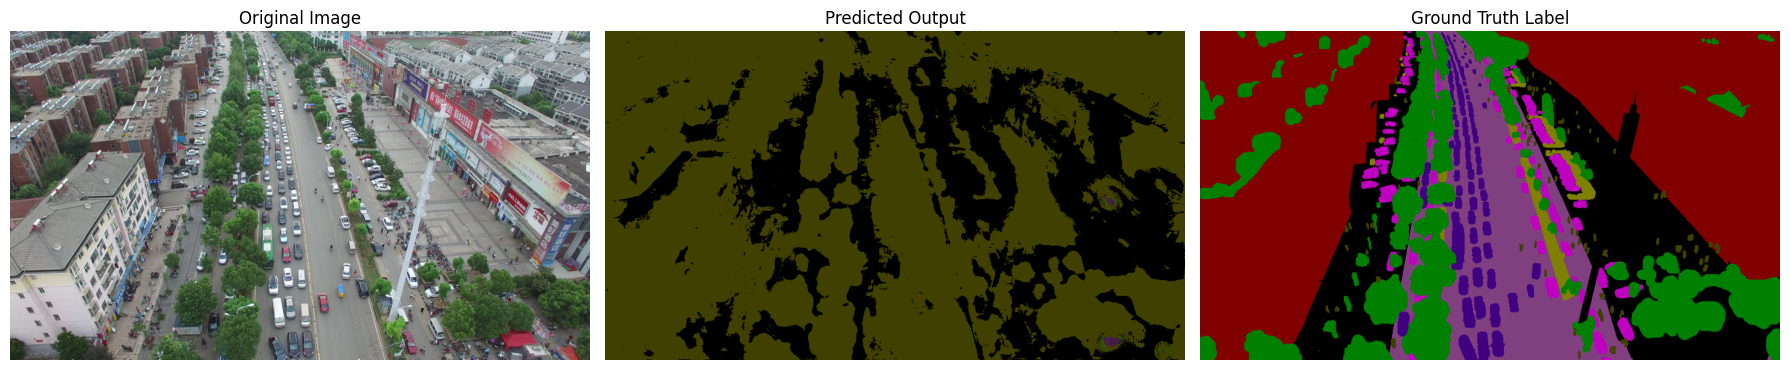

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

input_size = (544, 960, 3)  # Height = 544, Width = 960, Channels = 3


# Define the color mapping
COLOR_MAPPING = {
    0: (0, 0, 0),           # Background clutter
    1: (128, 0, 0),         # Building
    2: (128, 64, 128),      # Road
    3: (0, 128, 0),         # Tree
    4: (128, 128, 0),       # Low vegetation
    5: (64, 0, 128),        # Moving car
    6: (192, 0, 192),       # Static car
    7: (64, 64, 0),         # Human
}

# Function to apply color mapping to the predicted mask
def apply_color_map(prediction):
    # Initialize an empty image
    colorized_image = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

    # Apply the color mapping to each pixel in the prediction mask
    for class_idx in range(len(COLOR_MAPPING)):
        color = COLOR_MAPPING[class_idx]
        colorized_image[prediction == class_idx] = color

    return colorized_image

# Predict function with color mapping applied
def predict_and_display(model, image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=input_size[:2])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image

    # Make prediction
    prediction = model.predict(img_array)
    print("Class probabilities for a pixel before argmax:", prediction[0, 100, 100, :])
    prediction = np.argmax(prediction, axis=-1)[0]  # Convert to class indices (shape: (height, width))
    print("Class probabilities for a pixel after argmax:", prediction[100,100])

    # Apply color mapping to the prediction
    prediction = tf.cast(prediction, tf.int32)
    # Apply color mapping to the prediction
    colorized_output = apply_color_map(prediction)

    # Plot the original image, the label image, and the predicted image
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original image
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot the predicted image
    axes[1].imshow(colorized_output)
    axes[1].set_title("Predicted Output")
    axes[1].axis('off')

    # Load the ground truth label image (for comparison)
    mask_path = image_path.replace('Images', 'Labels')  # Assuming ground truth masks are named accordingly
    mask_img = image.load_img(mask_path, target_size=input_size[:2], color_mode='rgb')
    mask_array = np.array(mask_img)

    # Plot the ground truth label image
    axes[2].imshow(mask_array, cmap='tab20')  # Using a colormap for visualization
    axes[2].set_title("Ground Truth Label")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


image_path = '/content/IP-25/val_data/Images/seq18_000200.png'  # Replace with actual path

from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/IP project/unet_last.h5"  # Path to the saved model

model_temp = load_model(model_path)
# Assuming `unet` is your trained model

predict_and_display(model_temp, image_path)